#hybrid_models

In [1]:
#!git clone https://github.com/leonardoLavagna/qaoa

In [2]:
import os
os.chdir("qaoa")

In [3]:
#!pip install -r requirements.txt
#!pip install torch_geometric
#!pip install pennylane
#!pip install torch
#!pip install scikit-learn

In [4]:
import sys
import torch
import random
import pickle
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import pennylane as qml
import networkx as nx
from sklearn.model_selection import train_test_split
from torch_geometric.nn import global_mean_pool
from torch_geometric.data import Data, DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error

/Users/main/Desktop/qnns_for_maxcut/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [5]:
def set_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)

def exact_maxcut(q_s):
    n = q_s.shape[0]
    max_cut = 0
    for partition in range(1, 1 << (n - 1)):
        A = [i for i in range(n) if partition & (1 << i)]
        B = [i for i in range(n) if not (partition & (1 << i))]
        cut_value = sum(abs(q_s[i, j]) for i in A for j in B)
        max_cut = max(max_cut, cut_value)
    return max_cut

def graph_to_vector(adj, cut):
    edge_weights = adj[np.triu_indices(adj.shape[0], k=1)]
    return torch.tensor(edge_weights, dtype=torch.float32), torch.tensor([cut], dtype=torch.float32)

def graph_to_pyg(adj, cut, max_nodes=6):
    n = adj.shape[0]
    edge_index = torch.combinations(torch.arange(n), r=2).t()
    edge_weights = adj[np.triu_indices(n, k=1)]
    x = F.pad(torch.eye(n), (0, max_nodes - n), value=0)
    return Data(
        x=x,
        edge_index=edge_index,
        edge_attr=torch.tensor(edge_weights, dtype=torch.float32).unsqueeze(1),
        y=torch.tensor([cut], dtype=torch.float32)
    )

def load_graphs_from_nx(data_dir="data/", max_nodes=100):
    data_pyg, data_vec = [], []
    for fname in os.listdir(data_dir):
        if not fname.endswith(".nx"):
            continue
        with open(os.path.join(data_dir, fname), "rb") as f:
            graph_wrapper = pickle.load(f)
            G = graph_wrapper.get_graph()
        A = nx.to_numpy_array(G)
        cut = exact_maxcut(A)
        data_vec.append(graph_to_vector(A, cut))
        data_pyg.append(graph_to_pyg(A, cut, max_nodes=max_nodes))
    return train_test_split(data_pyg, test_size=0.2), train_test_split(data_vec, test_size=0.2)

def pad_vectors(data_vec, max_len=None):
    if max_len is None:
        max_len = max(x.shape[0] for x, _ in data_vec)
    padded_x, y_values = [], []
    for x, y in data_vec:
        x_padded = F.pad(x, (0, max_len - x.shape[0]), value=0)
        padded_x.append(x_padded)
        y_values.append(y)
    return torch.stack(padded_x), torch.stack(y_values), max_len

In [6]:
class QuantumLayer(nn.Module):
    def __init__(self, n_qubits, n_layers):
        super().__init__()
        self.dev = qml.device("default.qubit", wires=n_qubits)

        @qml.qnode(self.dev, interface="torch")
        def circuit(inputs, weights):
            for i in range(n_qubits):
                qml.RY(inputs[i], wires=i)
            for l in range(n_layers):
                for i in range(n_qubits):
                    qml.RZ(weights[l, i, 0], wires=i)
                    qml.RY(weights[l, i, 1], wires=i)
                for i in range(n_qubits - 1):
                    qml.CNOT(wires=[i, i + 1])
                qml.CNOT(wires=[n_qubits - 1, 0])
            return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

        weight_shapes = {"weights": (n_layers, n_qubits, 2)}
        self.qnn = qml.qnn.TorchLayer(circuit, weight_shapes)

    def forward(self, x):
        return torch.stack([self.qnn(v) for v in x])

class QuantumMLP(nn.Module):
    def __init__(self, input_dim=15, n_qubits=6, n_layers=2):
        super().__init__()
        self.fc = nn.Linear(input_dim, n_qubits)
        self.qnn = QuantumLayer(n_qubits, n_layers)
        self.out = nn.Linear(n_qubits, 1)

    def forward(self, x):
        x = torch.tanh(self.fc(x)) * torch.pi
        x = self.qnn(x)
        return self.out(x)

class HybridLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim=16, n_qubits=6, n_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, n_qubits)
        self.qnn = QuantumLayer(n_qubits, n_layers)
        self.out = nn.Linear(n_qubits, 1)

    def forward(self, x):
        _, (hn, _) = self.lstm(x)
        x = torch.tanh(self.fc(hn[-1])) * torch.pi
        x = self.qnn(x)
        return self.out(x)

class QNodeEmbedding(nn.Module):
    def __init__(self, n_qubits=4, n_layers=2):
        super().__init__()
        self.dev = qml.device("default.qubit", wires=n_qubits)

        @qml.qnode(self.dev, interface="torch")
        def circuit(inputs, weights):
            for i in range(n_qubits):
                qml.RY(inputs[i], wires=i)
            for l in range(n_layers):
                for i in range(n_qubits):
                    qml.RZ(weights[l, i, 0], wires=i)
                    qml.RY(weights[l, i, 1], wires=i)
                for i in range(n_qubits - 1):
                    qml.CNOT(wires=[i, i + 1])
                qml.CNOT(wires=[n_qubits - 1, 0])
            return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

        weight_shapes = {"weights": (n_layers, n_qubits, 2)}
        self.qnn = qml.qnn.TorchLayer(circuit, weight_shapes)

    def forward(self, x):
        return torch.stack([self.qnn(v) for v in x])

class QuantumGNN(nn.Module):
    def __init__(self, input_dim, quantum_dim=4, qlayers=2):
        super().__init__()
        self.encoder = nn.Linear(input_dim, quantum_dim)
        self.quantum = QNodeEmbedding(n_qubits=quantum_dim, n_layers=qlayers)
        self.out = nn.Linear(quantum_dim, 1)

    def forward(self, data):
        x = torch.tanh(self.encoder(data.x)) * torch.pi
        x = self.quantum(x)
        x = global_mean_pool(x, data.batch)
        return self.out(x)

In [7]:
def train(model, X_train, y_train, X_test, y_test, name="Model", epochs=100):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    loss_fn = nn.MSELoss()
    losses = []
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        out = model(X_train).squeeze()
        loss = loss_fn(out, y_train.squeeze())
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        print(f"[{name}] Epoch {epoch+1}: Loss = {loss.item():.4f}")
    model.eval()
    with torch.no_grad():
        preds = model(X_test).squeeze()
    return preds.tolist(), y_test.squeeze().tolist(), losses


def train_gnn(model, train_data, test_data, name="QGNN", epochs=100):
    loader = DataLoader(train_data, batch_size=16, shuffle=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    loss_fn = nn.MSELoss()
    losses = []
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for batch in loader:
            optimizer.zero_grad()
            out = model(batch).squeeze()
            loss = loss_fn(out, batch.y.squeeze())
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        losses.append(epoch_loss / len(loader))
        print(f"[{name}] Epoch {epoch+1}: Loss = {losses[-1]:.4f}")
    model.eval()
    preds, targets = [], []
    with torch.no_grad():
        for g in test_data:
            pred = model(g).item()
            preds.append(pred)
            targets.append(g.y.item())
    return preds, targets, losses

In [8]:
runs = 10
model_names = ["QuantumMLP", "HybridLSTM", "QuantumGNN"]

all_losses = {name: [] for name in model_names}
all_preds = {name: [] for name in model_names}
all_trues = []

for run in range(runs):
    print(f"\n=== Seeded Run {run+1} ===")
    set_seed(run)
    # Load and pad dataset
    (pyg_train, pyg_test), (vec_train, vec_test) = load_graphs_from_nx(data_dir="data/")
    X_train, y_train, max_len = pad_vectors(vec_train)
    X_test, y_test, _ = pad_vectors(vec_test, max_len=max_len)
    # QuantumMLP
    qmlp = QuantumMLP(input_dim=X_train.shape[1])
    preds, true, losses = train(qmlp, X_train, y_train, X_test, y_test, name="QuantumMLP")
    all_losses["QuantumMLP"].append(losses)
    all_preds["QuantumMLP"].append(preds)
    if run == 0:
        all_trues = true
    # HybridLSTM
    qlstm = HybridLSTM(input_dim=X_train.shape[1])
    X_train_seq = X_train.unsqueeze(1)
    X_test_seq = X_test.unsqueeze(1)
    preds, _, losses = train(qlstm, X_train_seq, y_train, X_test_seq, y_test, name="HybridLSTM")
    all_losses["HybridLSTM"].append(losses)
    all_preds["HybridLSTM"].append(preds)
    # QuantumGNN
    qgnn = QuantumGNN(input_dim=pyg_train[0].x.shape[1])
    preds, _, losses = train_gnn(qgnn, pyg_train, pyg_test, name="QuantumGNN")
    all_losses["QuantumGNN"].append(losses)
    all_preds["QuantumGNN"].append(preds)


=== Seeded Run 1 ===
[QuantumMLP] Epoch 1: Loss = 122.9124
[QuantumMLP] Epoch 2: Loss = 122.5133
[QuantumMLP] Epoch 3: Loss = 122.3097
[QuantumMLP] Epoch 4: Loss = 121.9697
[QuantumMLP] Epoch 5: Loss = 121.5359
[QuantumMLP] Epoch 6: Loss = 120.9965
[QuantumMLP] Epoch 7: Loss = 120.4694
[QuantumMLP] Epoch 8: Loss = 120.2983
[QuantumMLP] Epoch 9: Loss = 119.9123
[QuantumMLP] Epoch 10: Loss = 119.3518
[QuantumMLP] Epoch 11: Loss = 118.9459
[QuantumMLP] Epoch 12: Loss = 118.5989
[QuantumMLP] Epoch 13: Loss = 118.1020
[QuantumMLP] Epoch 14: Loss = 117.6259
[QuantumMLP] Epoch 15: Loss = 117.3074
[QuantumMLP] Epoch 16: Loss = 116.8727
[QuantumMLP] Epoch 17: Loss = 116.3455
[QuantumMLP] Epoch 18: Loss = 115.9167
[QuantumMLP] Epoch 19: Loss = 115.4296
[QuantumMLP] Epoch 20: Loss = 114.8190
[QuantumMLP] Epoch 21: Loss = 114.3444
[QuantumMLP] Epoch 22: Loss = 113.7851
[QuantumMLP] Epoch 23: Loss = 113.1602
[QuantumMLP] Epoch 24: Loss = 112.5941
[QuantumMLP] Epoch 25: Loss = 111.8982
[QuantumMLP]

/Users/main/Desktop/qnns_for_maxcut/.venv/lib/python3.9/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


[QuantumGNN] Epoch 1: Loss = 77.6320
[QuantumGNN] Epoch 2: Loss = 76.6919
[QuantumGNN] Epoch 3: Loss = 75.7857
[QuantumGNN] Epoch 4: Loss = 74.9360
[QuantumGNN] Epoch 5: Loss = 74.1397
[QuantumGNN] Epoch 6: Loss = 73.3785
[QuantumGNN] Epoch 7: Loss = 72.6450
[QuantumGNN] Epoch 8: Loss = 71.9369
[QuantumGNN] Epoch 9: Loss = 71.2499
[QuantumGNN] Epoch 10: Loss = 70.5760
[QuantumGNN] Epoch 11: Loss = 69.9058
[QuantumGNN] Epoch 12: Loss = 69.2309
[QuantumGNN] Epoch 13: Loss = 68.5461
[QuantumGNN] Epoch 14: Loss = 67.8500
[QuantumGNN] Epoch 15: Loss = 67.1456
[QuantumGNN] Epoch 16: Loss = 66.4382
[QuantumGNN] Epoch 17: Loss = 65.7344
[QuantumGNN] Epoch 18: Loss = 65.0403
[QuantumGNN] Epoch 19: Loss = 64.3608
[QuantumGNN] Epoch 20: Loss = 63.6998
[QuantumGNN] Epoch 21: Loss = 63.0600
[QuantumGNN] Epoch 22: Loss = 62.4433
[QuantumGNN] Epoch 23: Loss = 61.8513
[QuantumGNN] Epoch 24: Loss = 61.2847
[QuantumGNN] Epoch 25: Loss = 60.7434
[QuantumGNN] Epoch 26: Loss = 60.2263
[QuantumGNN] Epoch 27

/Users/main/Desktop/qnns_for_maxcut/.venv/lib/python3.9/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


[QuantumGNN] Epoch 1: Loss = 132.9244
[QuantumGNN] Epoch 2: Loss = 132.4197
[QuantumGNN] Epoch 3: Loss = 131.9353
[QuantumGNN] Epoch 4: Loss = 131.4668
[QuantumGNN] Epoch 5: Loss = 131.0058
[QuantumGNN] Epoch 6: Loss = 130.5426
[QuantumGNN] Epoch 7: Loss = 130.0686
[QuantumGNN] Epoch 8: Loss = 129.5796
[QuantumGNN] Epoch 9: Loss = 129.0751
[QuantumGNN] Epoch 10: Loss = 128.5585
[QuantumGNN] Epoch 11: Loss = 128.0367
[QuantumGNN] Epoch 12: Loss = 127.5191
[QuantumGNN] Epoch 13: Loss = 127.0150
[QuantumGNN] Epoch 14: Loss = 126.5292
[QuantumGNN] Epoch 15: Loss = 126.0593
[QuantumGNN] Epoch 16: Loss = 125.5971
[QuantumGNN] Epoch 17: Loss = 125.1323
[QuantumGNN] Epoch 18: Loss = 124.6563
[QuantumGNN] Epoch 19: Loss = 124.1632
[QuantumGNN] Epoch 20: Loss = 123.6491
[QuantumGNN] Epoch 21: Loss = 123.1131
[QuantumGNN] Epoch 22: Loss = 122.5576
[QuantumGNN] Epoch 23: Loss = 121.9872
[QuantumGNN] Epoch 24: Loss = 121.4077
[QuantumGNN] Epoch 25: Loss = 120.8247
[QuantumGNN] Epoch 26: Loss = 120.

/Users/main/Desktop/qnns_for_maxcut/.venv/lib/python3.9/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


[QuantumGNN] Epoch 1: Loss = 140.0099
[QuantumGNN] Epoch 2: Loss = 139.1577
[QuantumGNN] Epoch 3: Loss = 138.2854
[QuantumGNN] Epoch 4: Loss = 137.4148
[QuantumGNN] Epoch 5: Loss = 136.5702
[QuantumGNN] Epoch 6: Loss = 135.7760
[QuantumGNN] Epoch 7: Loss = 135.0524
[QuantumGNN] Epoch 8: Loss = 134.4102
[QuantumGNN] Epoch 9: Loss = 133.8467
[QuantumGNN] Epoch 10: Loss = 133.3468
[QuantumGNN] Epoch 11: Loss = 132.8904
[QuantumGNN] Epoch 12: Loss = 132.4579
[QuantumGNN] Epoch 13: Loss = 132.0340
[QuantumGNN] Epoch 14: Loss = 131.6076
[QuantumGNN] Epoch 15: Loss = 131.1713
[QuantumGNN] Epoch 16: Loss = 130.7205
[QuantumGNN] Epoch 17: Loss = 130.2531
[QuantumGNN] Epoch 18: Loss = 129.7691
[QuantumGNN] Epoch 19: Loss = 129.2704
[QuantumGNN] Epoch 20: Loss = 128.7599
[QuantumGNN] Epoch 21: Loss = 128.2417
[QuantumGNN] Epoch 22: Loss = 127.7202
[QuantumGNN] Epoch 23: Loss = 127.1995
[QuantumGNN] Epoch 24: Loss = 126.6833
[QuantumGNN] Epoch 25: Loss = 126.1732
[QuantumGNN] Epoch 26: Loss = 125.

/Users/main/Desktop/qnns_for_maxcut/.venv/lib/python3.9/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


[QuantumGNN] Epoch 1: Loss = 139.6515
[QuantumGNN] Epoch 2: Loss = 138.7927
[QuantumGNN] Epoch 3: Loss = 137.9803
[QuantumGNN] Epoch 4: Loss = 137.2185
[QuantumGNN] Epoch 5: Loss = 136.5034
[QuantumGNN] Epoch 6: Loss = 135.8284
[QuantumGNN] Epoch 7: Loss = 135.1857
[QuantumGNN] Epoch 8: Loss = 134.5673
[QuantumGNN] Epoch 9: Loss = 133.9648
[QuantumGNN] Epoch 10: Loss = 133.3727
[QuantumGNN] Epoch 11: Loss = 132.7891
[QuantumGNN] Epoch 12: Loss = 132.2152
[QuantumGNN] Epoch 13: Loss = 131.6525
[QuantumGNN] Epoch 14: Loss = 131.1009
[QuantumGNN] Epoch 15: Loss = 130.5586
[QuantumGNN] Epoch 16: Loss = 130.0237
[QuantumGNN] Epoch 17: Loss = 129.4958
[QuantumGNN] Epoch 18: Loss = 128.9758
[QuantumGNN] Epoch 19: Loss = 128.4645
[QuantumGNN] Epoch 20: Loss = 127.9619
[QuantumGNN] Epoch 21: Loss = 127.4656
[QuantumGNN] Epoch 22: Loss = 126.9726
[QuantumGNN] Epoch 23: Loss = 126.4806
[QuantumGNN] Epoch 24: Loss = 125.9891
[QuantumGNN] Epoch 25: Loss = 125.4981
[QuantumGNN] Epoch 26: Loss = 125.

/Users/main/Desktop/qnns_for_maxcut/.venv/lib/python3.9/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


[QuantumGNN] Epoch 1: Loss = 133.6710
[QuantumGNN] Epoch 2: Loss = 133.1458
[QuantumGNN] Epoch 3: Loss = 132.5665
[QuantumGNN] Epoch 4: Loss = 131.9355
[QuantumGNN] Epoch 5: Loss = 131.2585
[QuantumGNN] Epoch 6: Loss = 130.5433
[QuantumGNN] Epoch 7: Loss = 129.7984
[QuantumGNN] Epoch 8: Loss = 129.0325
[QuantumGNN] Epoch 9: Loss = 128.2536
[QuantumGNN] Epoch 10: Loss = 127.4700
[QuantumGNN] Epoch 11: Loss = 126.6891
[QuantumGNN] Epoch 12: Loss = 125.9169
[QuantumGNN] Epoch 13: Loss = 125.1558
[QuantumGNN] Epoch 14: Loss = 124.4044
[QuantumGNN] Epoch 15: Loss = 123.6570
[QuantumGNN] Epoch 16: Loss = 122.9047
[QuantumGNN] Epoch 17: Loss = 122.1363
[QuantumGNN] Epoch 18: Loss = 121.3418
[QuantumGNN] Epoch 19: Loss = 120.5149
[QuantumGNN] Epoch 20: Loss = 119.6542
[QuantumGNN] Epoch 21: Loss = 118.7632
[QuantumGNN] Epoch 22: Loss = 117.8479
[QuantumGNN] Epoch 23: Loss = 116.9161
[QuantumGNN] Epoch 24: Loss = 115.9745
[QuantumGNN] Epoch 25: Loss = 115.0282
[QuantumGNN] Epoch 26: Loss = 114.

/Users/main/Desktop/qnns_for_maxcut/.venv/lib/python3.9/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


[QuantumGNN] Epoch 1: Loss = 144.9915
[QuantumGNN] Epoch 2: Loss = 144.4073
[QuantumGNN] Epoch 3: Loss = 143.8074
[QuantumGNN] Epoch 4: Loss = 143.1868
[QuantumGNN] Epoch 5: Loss = 142.5378
[QuantumGNN] Epoch 6: Loss = 141.8641
[QuantumGNN] Epoch 7: Loss = 141.1746
[QuantumGNN] Epoch 8: Loss = 140.4812
[QuantumGNN] Epoch 9: Loss = 139.7968
[QuantumGNN] Epoch 10: Loss = 139.1324
[QuantumGNN] Epoch 11: Loss = 138.4950
[QuantumGNN] Epoch 12: Loss = 137.8854
[QuantumGNN] Epoch 13: Loss = 137.2966
[QuantumGNN] Epoch 14: Loss = 136.7161
[QuantumGNN] Epoch 15: Loss = 136.1326
[QuantumGNN] Epoch 16: Loss = 135.5396
[QuantumGNN] Epoch 17: Loss = 134.9356
[QuantumGNN] Epoch 18: Loss = 134.3228
[QuantumGNN] Epoch 19: Loss = 133.7052
[QuantumGNN] Epoch 20: Loss = 133.0860
[QuantumGNN] Epoch 21: Loss = 132.4664
[QuantumGNN] Epoch 22: Loss = 131.8463
[QuantumGNN] Epoch 23: Loss = 131.2244
[QuantumGNN] Epoch 24: Loss = 130.5994
[QuantumGNN] Epoch 25: Loss = 129.9692
[QuantumGNN] Epoch 26: Loss = 129.

/Users/main/Desktop/qnns_for_maxcut/.venv/lib/python3.9/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


[QuantumGNN] Epoch 1: Loss = 141.7318
[QuantumGNN] Epoch 2: Loss = 140.0628
[QuantumGNN] Epoch 3: Loss = 138.4700
[QuantumGNN] Epoch 4: Loss = 137.0039
[QuantumGNN] Epoch 5: Loss = 135.6979
[QuantumGNN] Epoch 6: Loss = 134.5559
[QuantumGNN] Epoch 7: Loss = 133.5502
[QuantumGNN] Epoch 8: Loss = 132.6342
[QuantumGNN] Epoch 9: Loss = 131.7626
[QuantumGNN] Epoch 10: Loss = 130.9025
[QuantumGNN] Epoch 11: Loss = 130.0352
[QuantumGNN] Epoch 12: Loss = 129.1523
[QuantumGNN] Epoch 13: Loss = 128.2520
[QuantumGNN] Epoch 14: Loss = 127.3369
[QuantumGNN] Epoch 15: Loss = 126.4132
[QuantumGNN] Epoch 16: Loss = 125.4901
[QuantumGNN] Epoch 17: Loss = 124.5779
[QuantumGNN] Epoch 18: Loss = 123.6874
[QuantumGNN] Epoch 19: Loss = 122.8275
[QuantumGNN] Epoch 20: Loss = 122.0032
[QuantumGNN] Epoch 21: Loss = 121.2152
[QuantumGNN] Epoch 22: Loss = 120.4597
[QuantumGNN] Epoch 23: Loss = 119.7302
[QuantumGNN] Epoch 24: Loss = 119.0189
[QuantumGNN] Epoch 25: Loss = 118.3186
[QuantumGNN] Epoch 26: Loss = 117.

/Users/main/Desktop/qnns_for_maxcut/.venv/lib/python3.9/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


[QuantumGNN] Epoch 1: Loss = 94.9431
[QuantumGNN] Epoch 2: Loss = 94.3879
[QuantumGNN] Epoch 3: Loss = 93.8231
[QuantumGNN] Epoch 4: Loss = 93.2385
[QuantumGNN] Epoch 5: Loss = 92.6307
[QuantumGNN] Epoch 6: Loss = 91.9897
[QuantumGNN] Epoch 7: Loss = 91.3098
[QuantumGNN] Epoch 8: Loss = 90.5903
[QuantumGNN] Epoch 9: Loss = 89.8342
[QuantumGNN] Epoch 10: Loss = 89.0486
[QuantumGNN] Epoch 11: Loss = 88.2443
[QuantumGNN] Epoch 12: Loss = 87.4347
[QuantumGNN] Epoch 13: Loss = 86.6347
[QuantumGNN] Epoch 14: Loss = 85.8590
[QuantumGNN] Epoch 15: Loss = 85.1207
[QuantumGNN] Epoch 16: Loss = 84.4296
[QuantumGNN] Epoch 17: Loss = 83.7912
[QuantumGNN] Epoch 18: Loss = 83.2049
[QuantumGNN] Epoch 19: Loss = 82.6647
[QuantumGNN] Epoch 20: Loss = 82.1598
[QuantumGNN] Epoch 21: Loss = 81.6775
[QuantumGNN] Epoch 22: Loss = 81.2061
[QuantumGNN] Epoch 23: Loss = 80.7357
[QuantumGNN] Epoch 24: Loss = 80.2596
[QuantumGNN] Epoch 25: Loss = 79.7735
[QuantumGNN] Epoch 26: Loss = 79.2755
[QuantumGNN] Epoch 27

/Users/main/Desktop/qnns_for_maxcut/.venv/lib/python3.9/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


[QuantumGNN] Epoch 1: Loss = 147.7741
[QuantumGNN] Epoch 2: Loss = 146.8615
[QuantumGNN] Epoch 3: Loss = 145.9173
[QuantumGNN] Epoch 4: Loss = 144.9635
[QuantumGNN] Epoch 5: Loss = 144.0170
[QuantumGNN] Epoch 6: Loss = 143.0886
[QuantumGNN] Epoch 7: Loss = 142.1877
[QuantumGNN] Epoch 8: Loss = 141.3208
[QuantumGNN] Epoch 9: Loss = 140.4863
[QuantumGNN] Epoch 10: Loss = 139.6768
[QuantumGNN] Epoch 11: Loss = 138.8846
[QuantumGNN] Epoch 12: Loss = 138.1047
[QuantumGNN] Epoch 13: Loss = 137.3312
[QuantumGNN] Epoch 14: Loss = 136.5567
[QuantumGNN] Epoch 15: Loss = 135.7731
[QuantumGNN] Epoch 16: Loss = 134.9707
[QuantumGNN] Epoch 17: Loss = 134.1392
[QuantumGNN] Epoch 18: Loss = 133.2704
[QuantumGNN] Epoch 19: Loss = 132.3615
[QuantumGNN] Epoch 20: Loss = 131.4149
[QuantumGNN] Epoch 21: Loss = 130.4382
[QuantumGNN] Epoch 22: Loss = 129.4426
[QuantumGNN] Epoch 23: Loss = 128.4417
[QuantumGNN] Epoch 24: Loss = 127.4489
[QuantumGNN] Epoch 25: Loss = 126.4739
[QuantumGNN] Epoch 26: Loss = 125.

/Users/main/Desktop/qnns_for_maxcut/.venv/lib/python3.9/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


[QuantumGNN] Epoch 1: Loss = 113.4131
[QuantumGNN] Epoch 2: Loss = 112.5536
[QuantumGNN] Epoch 3: Loss = 111.7617
[QuantumGNN] Epoch 4: Loss = 111.0312
[QuantumGNN] Epoch 5: Loss = 110.3360
[QuantumGNN] Epoch 6: Loss = 109.6447
[QuantumGNN] Epoch 7: Loss = 108.9414
[QuantumGNN] Epoch 8: Loss = 108.2237
[QuantumGNN] Epoch 9: Loss = 107.4958
[QuantumGNN] Epoch 10: Loss = 106.7643
[QuantumGNN] Epoch 11: Loss = 106.0347
[QuantumGNN] Epoch 12: Loss = 105.3083
[QuantumGNN] Epoch 13: Loss = 104.5821
[QuantumGNN] Epoch 14: Loss = 103.8495
[QuantumGNN] Epoch 15: Loss = 103.1041
[QuantumGNN] Epoch 16: Loss = 102.3431
[QuantumGNN] Epoch 17: Loss = 101.5688
[QuantumGNN] Epoch 18: Loss = 100.7873
[QuantumGNN] Epoch 19: Loss = 100.0048
[QuantumGNN] Epoch 20: Loss = 99.2256
[QuantumGNN] Epoch 21: Loss = 98.4503
[QuantumGNN] Epoch 22: Loss = 97.6764
[QuantumGNN] Epoch 23: Loss = 96.9014
[QuantumGNN] Epoch 24: Loss = 96.1242
[QuantumGNN] Epoch 25: Loss = 95.3457
[QuantumGNN] Epoch 26: Loss = 94.5667
[Q

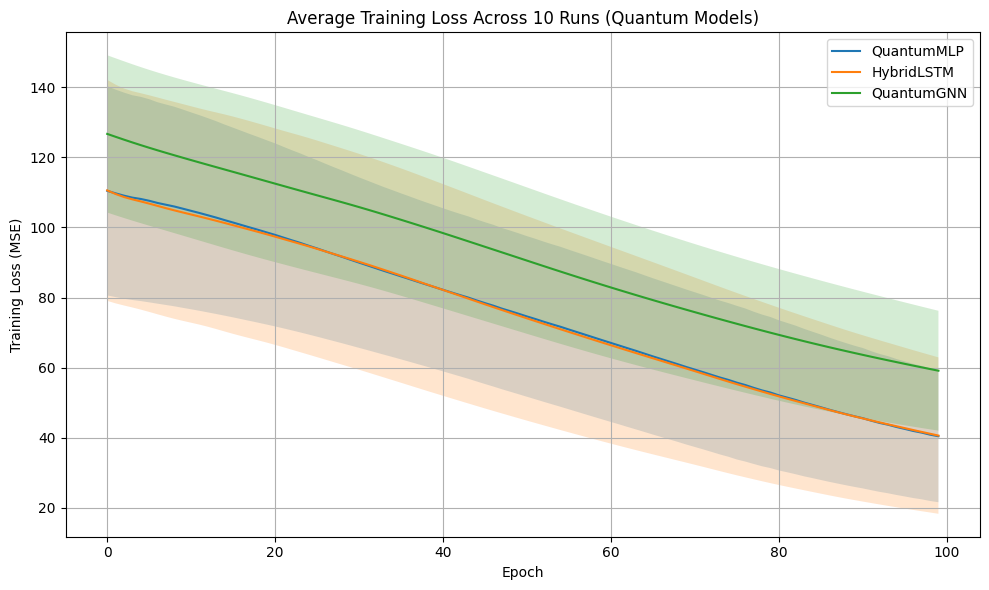

In [9]:
plt.figure(figsize=(10, 6))
for name, runs_losses in all_losses.items():
    losses_matrix = np.array([np.array(l) for l in runs_losses])
    mean_loss = losses_matrix.mean(axis=0)
    std_loss = losses_matrix.std(axis=0)
    epochs = np.arange(len(mean_loss))
    plt.plot(epochs, mean_loss, label=name)
    plt.fill_between(epochs, mean_loss - std_loss, mean_loss + std_loss, alpha=0.2)

plt.xlabel("Epoch")
plt.ylabel("Training Loss (MSE)")
plt.title("Average Training Loss Across 10 Runs (Quantum Models)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("loss_qaoa_dataset_2.png", dpi=300)
plt.show()

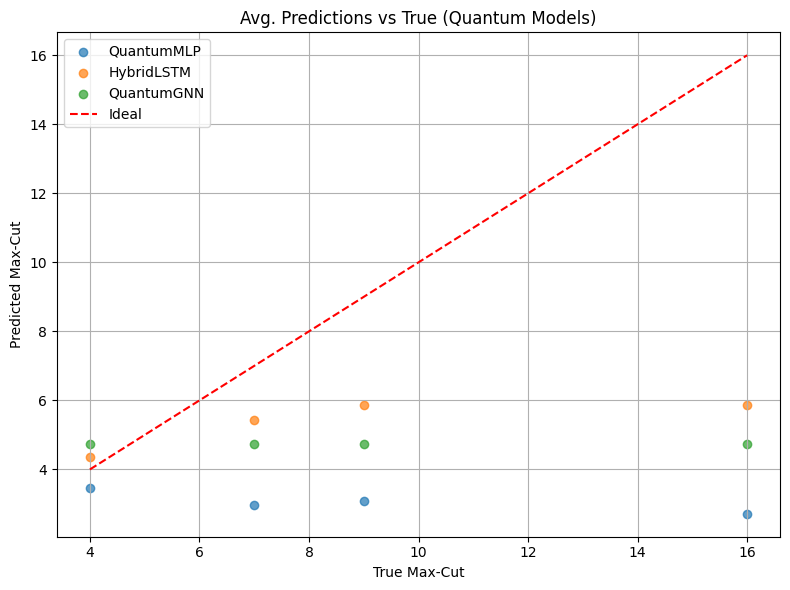

In [10]:
plt.figure(figsize=(8, 6))
true_vals = np.array(all_trues)

for name, runs_preds in all_preds.items():
    preds_matrix = np.array(runs_preds)
    mean_preds = preds_matrix.mean(axis=0)
    plt.scatter(true_vals, mean_preds, label=name, alpha=0.7)

lims = [min(true_vals.min(), mean_preds.min()), max(true_vals.max(), mean_preds.max())]
plt.plot(lims, lims, 'r--', label="Ideal")
plt.xlabel("True Max-Cut")
plt.ylabel("Predicted Max-Cut")
plt.title("Avg. Predictions vs True (Quantum Models)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("avg_pred_vs_true_qaoa_dataset_2.png", dpi=300)
plt.show()

In [11]:
results_lines = []
results_lines.append("--- Aggregated Test Evaluation over All Runs (Quantum Models) ---\n")

true_vals = np.array(all_trues)

for name, runs_preds in all_preds.items():
    preds_matrix = np.array(runs_preds)
    mean_preds = preds_matrix.mean(axis=0)
    std_preds = preds_matrix.std(axis=0)
    # Metrics
    mse = mean_squared_error(true_vals, mean_preds)
    mae = mean_absolute_error(true_vals, mean_preds)
    approx_ratios = mean_preds / np.maximum(true_vals, 1e-6)
    mean_ratio = approx_ratios.mean()
    std_ratio = approx_ratios.std()
    # Store results as string
    results_lines.append(f"{name} Results:")
    results_lines.append(f"  MSE:            {mse:.4f}")
    results_lines.append(f"  MAE:            {mae:.4f}")
    results_lines.append(f"  Approx. Ratio:  {mean_ratio:.4f} ± {std_ratio:.4f}\n")

output_path = "results_qaoa_dataset_2.txt"
with open(output_path, "w") as f:
    f.write("\n".join(results_lines))

print(f"\n✅ Quantum results saved to {output_path}")


✅ Quantum results saved to results_qaoa_dataset_2.txt


## Random graphs only

In [12]:
def generate_erdos_renyi_dataset(n_samples=300, min_nodes=4, max_nodes=16, p=0.5, weight_range=5, test_ratio=0.2):
    data_pyg, data_vec = [], []
    for _ in range(n_samples):
        n = np.random.randint(min_nodes, max_nodes + 1)
        G = nx.erdos_renyi_graph(n, p)
        if len(G.edges) == 0:
            continue
        # Assign random weights
        for u, v in G.edges():
            G[u][v]['weight'] = np.random.randint(-weight_range, weight_range + 1)
        adj = nx.to_numpy_array(G, weight='weight')
        cut = exact_maxcut(adj)
        data_vec.append(graph_to_vector(adj, cut))
        data_pyg.append(graph_to_pyg(adj, cut, max_nodes=max_nodes))
    return train_test_split(data_pyg, test_size=test_ratio), train_test_split(data_vec, test_size=test_ratio)

In [13]:
runs = 10
model_names = ["QuantumMLP", "HybridLSTM", "QuantumGNN"]

all_losses = {name: [] for name in model_names}
all_preds = {name: [] for name in model_names}
all_trues = []

for run in range(runs):
    print(f"\n=== Seeded Run {run+1} ===")
    set_seed(run)
    # Load and pad dataset
    (pyg_train, pyg_test), (vec_train, vec_test) = generate_erdos_renyi_dataset()
    X_train, y_train, max_len = pad_vectors(vec_train)
    X_test, y_test, _ = pad_vectors(vec_test, max_len=max_len)
    # QuantumMLP
    qmlp = QuantumMLP(input_dim=X_train.shape[1])
    preds, true, losses = train(qmlp, X_train, y_train, X_test, y_test, name="QuantumMLP")
    all_losses["QuantumMLP"].append(losses)
    all_preds["QuantumMLP"].append(preds)
    if run == 0:
        all_trues = true
    # HybridLSTM
    qlstm = HybridLSTM(input_dim=X_train.shape[1])
    X_train_seq = X_train.unsqueeze(1)
    X_test_seq = X_test.unsqueeze(1)
    preds, _, losses = train(qlstm, X_train_seq, y_train, X_test_seq, y_test, name="HybridLSTM")
    all_losses["HybridLSTM"].append(losses)
    all_preds["HybridLSTM"].append(preds)
    # QuantumGNN
    qgnn = QuantumGNN(input_dim=pyg_train[0].x.shape[1])
    preds, _, losses = train_gnn(qgnn, pyg_train, pyg_test, name="QuantumGNN")
    all_losses["QuantumGNN"].append(losses)
    all_preds["QuantumGNN"].append(preds)


=== Seeded Run 1 ===
[QuantumMLP] Epoch 1: Loss = 4340.0542
[QuantumMLP] Epoch 2: Loss = 4336.2983
[QuantumMLP] Epoch 3: Loss = 4332.3696
[QuantumMLP] Epoch 4: Loss = 4329.3672
[QuantumMLP] Epoch 5: Loss = 4326.3833
[QuantumMLP] Epoch 6: Loss = 4323.2573
[QuantumMLP] Epoch 7: Loss = 4320.2612
[QuantumMLP] Epoch 8: Loss = 4317.2559
[QuantumMLP] Epoch 9: Loss = 4314.0269
[QuantumMLP] Epoch 10: Loss = 4310.9106
[QuantumMLP] Epoch 11: Loss = 4308.0532
[QuantumMLP] Epoch 12: Loss = 4304.9814
[QuantumMLP] Epoch 13: Loss = 4301.6118
[QuantumMLP] Epoch 14: Loss = 4298.2319
[QuantumMLP] Epoch 15: Loss = 4295.0703
[QuantumMLP] Epoch 16: Loss = 4291.7881
[QuantumMLP] Epoch 17: Loss = 4288.3799
[QuantumMLP] Epoch 18: Loss = 4284.9365
[QuantumMLP] Epoch 19: Loss = 4281.4985
[QuantumMLP] Epoch 20: Loss = 4278.0078
[QuantumMLP] Epoch 21: Loss = 4274.3335
[QuantumMLP] Epoch 22: Loss = 4270.9253
[QuantumMLP] Epoch 23: Loss = 4267.5308
[QuantumMLP] Epoch 24: Loss = 4263.8848
[QuantumMLP] Epoch 25: Loss

/Users/main/Desktop/qnns_for_maxcut/.venv/lib/python3.9/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


[QuantumGNN] Epoch 1: Loss = 4180.3354
[QuantumGNN] Epoch 2: Loss = 4132.9462
[QuantumGNN] Epoch 3: Loss = 4052.1759
[QuantumGNN] Epoch 4: Loss = 3936.0003
[QuantumGNN] Epoch 5: Loss = 3805.7788
[QuantumGNN] Epoch 6: Loss = 3700.1808
[QuantumGNN] Epoch 7: Loss = 3616.5634
[QuantumGNN] Epoch 8: Loss = 3541.3357
[QuantumGNN] Epoch 9: Loss = 3469.0520
[QuantumGNN] Epoch 10: Loss = 3400.1117
[QuantumGNN] Epoch 11: Loss = 3337.4246
[QuantumGNN] Epoch 12: Loss = 3274.0630
[QuantumGNN] Epoch 13: Loss = 3215.8264
[QuantumGNN] Epoch 14: Loss = 3157.2501
[QuantumGNN] Epoch 15: Loss = 3102.4367
[QuantumGNN] Epoch 16: Loss = 3047.0623
[QuantumGNN] Epoch 17: Loss = 2996.3292
[QuantumGNN] Epoch 18: Loss = 2944.5719
[QuantumGNN] Epoch 19: Loss = 2895.6070
[QuantumGNN] Epoch 20: Loss = 2846.0459
[QuantumGNN] Epoch 21: Loss = 2801.3912
[QuantumGNN] Epoch 22: Loss = 2755.4005
[QuantumGNN] Epoch 23: Loss = 2709.8615
[QuantumGNN] Epoch 24: Loss = 2668.4849
[QuantumGNN] Epoch 25: Loss = 2626.2145
[QuantumG

/Users/main/Desktop/qnns_for_maxcut/.venv/lib/python3.9/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


[QuantumGNN] Epoch 1: Loss = 3920.6543
[QuantumGNN] Epoch 2: Loss = 3873.1589
[QuantumGNN] Epoch 3: Loss = 3824.6278
[QuantumGNN] Epoch 4: Loss = 3765.0307
[QuantumGNN] Epoch 5: Loss = 3698.1910
[QuantumGNN] Epoch 6: Loss = 3635.4502
[QuantumGNN] Epoch 7: Loss = 3570.4369
[QuantumGNN] Epoch 8: Loss = 3494.2667
[QuantumGNN] Epoch 9: Loss = 3411.9675
[QuantumGNN] Epoch 10: Loss = 3280.2484
[QuantumGNN] Epoch 11: Loss = 3106.1292
[QuantumGNN] Epoch 12: Loss = 2958.4323
[QuantumGNN] Epoch 13: Loss = 2868.0997
[QuantumGNN] Epoch 14: Loss = 2795.5070
[QuantumGNN] Epoch 15: Loss = 2726.4864
[QuantumGNN] Epoch 16: Loss = 2663.0930
[QuantumGNN] Epoch 17: Loss = 2602.9088
[QuantumGNN] Epoch 18: Loss = 2546.6193
[QuantumGNN] Epoch 19: Loss = 2491.9152
[QuantumGNN] Epoch 20: Loss = 2440.9007
[QuantumGNN] Epoch 21: Loss = 2391.7154
[QuantumGNN] Epoch 22: Loss = 2344.0054
[QuantumGNN] Epoch 23: Loss = 2299.6396
[QuantumGNN] Epoch 24: Loss = 2256.8952
[QuantumGNN] Epoch 25: Loss = 2215.7040
[QuantumG

/Users/main/Desktop/qnns_for_maxcut/.venv/lib/python3.9/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


[QuantumGNN] Epoch 1: Loss = 4417.0646
[QuantumGNN] Epoch 2: Loss = 4363.3924
[QuantumGNN] Epoch 3: Loss = 4308.2560
[QuantumGNN] Epoch 4: Loss = 4240.3887
[QuantumGNN] Epoch 5: Loss = 4164.2464
[QuantumGNN] Epoch 6: Loss = 4089.7821
[QuantumGNN] Epoch 7: Loss = 4019.3355
[QuantumGNN] Epoch 8: Loss = 3954.0796
[QuantumGNN] Epoch 9: Loss = 3896.2351
[QuantumGNN] Epoch 10: Loss = 3841.8886
[QuantumGNN] Epoch 11: Loss = 3789.1099
[QuantumGNN] Epoch 12: Loss = 3739.4119
[QuantumGNN] Epoch 13: Loss = 3690.8932
[QuantumGNN] Epoch 14: Loss = 3645.2550
[QuantumGNN] Epoch 15: Loss = 3599.2910
[QuantumGNN] Epoch 16: Loss = 3554.6196
[QuantumGNN] Epoch 17: Loss = 3511.2089
[QuantumGNN] Epoch 18: Loss = 3469.7149
[QuantumGNN] Epoch 19: Loss = 3427.7354
[QuantumGNN] Epoch 20: Loss = 3387.5231
[QuantumGNN] Epoch 21: Loss = 3347.8381
[QuantumGNN] Epoch 22: Loss = 3309.6501
[QuantumGNN] Epoch 23: Loss = 3270.6943
[QuantumGNN] Epoch 24: Loss = 3232.9446
[QuantumGNN] Epoch 25: Loss = 3195.9255
[QuantumG

/Users/main/Desktop/qnns_for_maxcut/.venv/lib/python3.9/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


[QuantumGNN] Epoch 1: Loss = 4463.5882
[QuantumGNN] Epoch 2: Loss = 4405.3972
[QuantumGNN] Epoch 3: Loss = 4336.6312
[QuantumGNN] Epoch 4: Loss = 4256.8131
[QuantumGNN] Epoch 5: Loss = 4135.8444
[QuantumGNN] Epoch 6: Loss = 3972.7043
[QuantumGNN] Epoch 7: Loss = 3823.2541
[QuantumGNN] Epoch 8: Loss = 3694.0667
[QuantumGNN] Epoch 9: Loss = 3592.6424
[QuantumGNN] Epoch 10: Loss = 3499.8816
[QuantumGNN] Epoch 11: Loss = 3421.0894
[QuantumGNN] Epoch 12: Loss = 3345.6023
[QuantumGNN] Epoch 13: Loss = 3273.8663
[QuantumGNN] Epoch 14: Loss = 3206.4991
[QuantumGNN] Epoch 15: Loss = 3141.4433
[QuantumGNN] Epoch 16: Loss = 3077.3956
[QuantumGNN] Epoch 17: Loss = 3017.1398
[QuantumGNN] Epoch 18: Loss = 2959.9768
[QuantumGNN] Epoch 19: Loss = 2904.2468
[QuantumGNN] Epoch 20: Loss = 2849.4842
[QuantumGNN] Epoch 21: Loss = 2799.0924
[QuantumGNN] Epoch 22: Loss = 2746.6126
[QuantumGNN] Epoch 23: Loss = 2698.1841
[QuantumGNN] Epoch 24: Loss = 2652.2166
[QuantumGNN] Epoch 25: Loss = 2605.1887
[QuantumG

/Users/main/Desktop/qnns_for_maxcut/.venv/lib/python3.9/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


[QuantumGNN] Epoch 1: Loss = 4403.4949
[QuantumGNN] Epoch 2: Loss = 4293.2251
[QuantumGNN] Epoch 3: Loss = 4187.4899
[QuantumGNN] Epoch 4: Loss = 4089.5764
[QuantumGNN] Epoch 5: Loss = 4000.8831
[QuantumGNN] Epoch 6: Loss = 3917.9730
[QuantumGNN] Epoch 7: Loss = 3836.9194
[QuantumGNN] Epoch 8: Loss = 3760.4571
[QuantumGNN] Epoch 9: Loss = 3685.3958
[QuantumGNN] Epoch 10: Loss = 3615.0233
[QuantumGNN] Epoch 11: Loss = 3544.2639
[QuantumGNN] Epoch 12: Loss = 3475.2553
[QuantumGNN] Epoch 13: Loss = 3408.8077
[QuantumGNN] Epoch 14: Loss = 3345.1208
[QuantumGNN] Epoch 15: Loss = 3282.4688
[QuantumGNN] Epoch 16: Loss = 3220.9734
[QuantumGNN] Epoch 17: Loss = 3161.7639
[QuantumGNN] Epoch 18: Loss = 3103.9056
[QuantumGNN] Epoch 19: Loss = 3046.1915
[QuantumGNN] Epoch 20: Loss = 2992.3888
[QuantumGNN] Epoch 21: Loss = 2937.5668
[QuantumGNN] Epoch 22: Loss = 2885.2275
[QuantumGNN] Epoch 23: Loss = 2834.6465
[QuantumGNN] Epoch 24: Loss = 2785.2786
[QuantumGNN] Epoch 25: Loss = 2735.9656
[QuantumG

/Users/main/Desktop/qnns_for_maxcut/.venv/lib/python3.9/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


[QuantumGNN] Epoch 1: Loss = 4110.3916
[QuantumGNN] Epoch 2: Loss = 4033.1284
[QuantumGNN] Epoch 3: Loss = 3961.3774
[QuantumGNN] Epoch 4: Loss = 3869.0191
[QuantumGNN] Epoch 5: Loss = 3756.8056
[QuantumGNN] Epoch 6: Loss = 3624.0581
[QuantumGNN] Epoch 7: Loss = 3491.2544
[QuantumGNN] Epoch 8: Loss = 3386.4822
[QuantumGNN] Epoch 9: Loss = 3292.2872
[QuantumGNN] Epoch 10: Loss = 3212.7937
[QuantumGNN] Epoch 11: Loss = 3151.8282
[QuantumGNN] Epoch 12: Loss = 3079.1889
[QuantumGNN] Epoch 13: Loss = 3015.3712
[QuantumGNN] Epoch 14: Loss = 2958.6275
[QuantumGNN] Epoch 15: Loss = 2890.4431
[QuantumGNN] Epoch 16: Loss = 2836.6912
[QuantumGNN] Epoch 17: Loss = 2770.5635
[QuantumGNN] Epoch 18: Loss = 2716.3150
[QuantumGNN] Epoch 19: Loss = 2666.3981
[QuantumGNN] Epoch 20: Loss = 2617.3418
[QuantumGNN] Epoch 21: Loss = 2563.3939
[QuantumGNN] Epoch 22: Loss = 2521.7677
[QuantumGNN] Epoch 23: Loss = 2482.5302
[QuantumGNN] Epoch 24: Loss = 2430.9805
[QuantumGNN] Epoch 25: Loss = 2397.3721
[QuantumG

/Users/main/Desktop/qnns_for_maxcut/.venv/lib/python3.9/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


[QuantumGNN] Epoch 1: Loss = 4468.9757
[QuantumGNN] Epoch 2: Loss = 4427.2300
[QuantumGNN] Epoch 3: Loss = 4395.8276
[QuantumGNN] Epoch 4: Loss = 4337.0576
[QuantumGNN] Epoch 5: Loss = 4261.1315
[QuantumGNN] Epoch 6: Loss = 4166.1045
[QuantumGNN] Epoch 7: Loss = 4057.3387
[QuantumGNN] Epoch 8: Loss = 3989.1975
[QuantumGNN] Epoch 9: Loss = 3884.3638
[QuantumGNN] Epoch 10: Loss = 3770.2505
[QuantumGNN] Epoch 11: Loss = 3652.3943
[QuantumGNN] Epoch 12: Loss = 3564.4650
[QuantumGNN] Epoch 13: Loss = 3475.5553
[QuantumGNN] Epoch 14: Loss = 3401.1550
[QuantumGNN] Epoch 15: Loss = 3319.9186
[QuantumGNN] Epoch 16: Loss = 3250.9898
[QuantumGNN] Epoch 17: Loss = 3194.5264
[QuantumGNN] Epoch 18: Loss = 3135.6207
[QuantumGNN] Epoch 19: Loss = 3063.0285
[QuantumGNN] Epoch 20: Loss = 3008.3327
[QuantumGNN] Epoch 21: Loss = 2952.0959
[QuantumGNN] Epoch 22: Loss = 2890.8682
[QuantumGNN] Epoch 23: Loss = 2834.4775
[QuantumGNN] Epoch 24: Loss = 2789.7558
[QuantumGNN] Epoch 25: Loss = 2738.0240
[QuantumG

/Users/main/Desktop/qnns_for_maxcut/.venv/lib/python3.9/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


[QuantumGNN] Epoch 1: Loss = 4590.6218
[QuantumGNN] Epoch 2: Loss = 4518.3856
[QuantumGNN] Epoch 3: Loss = 4432.9596
[QuantumGNN] Epoch 4: Loss = 4332.4307
[QuantumGNN] Epoch 5: Loss = 4201.8608
[QuantumGNN] Epoch 6: Loss = 4059.3637
[QuantumGNN] Epoch 7: Loss = 3947.4948
[QuantumGNN] Epoch 8: Loss = 3857.1188
[QuantumGNN] Epoch 9: Loss = 3775.2286
[QuantumGNN] Epoch 10: Loss = 3694.3434
[QuantumGNN] Epoch 11: Loss = 3618.9439
[QuantumGNN] Epoch 12: Loss = 3548.5174
[QuantumGNN] Epoch 13: Loss = 3477.7060
[QuantumGNN] Epoch 14: Loss = 3412.3685
[QuantumGNN] Epoch 15: Loss = 3347.5293
[QuantumGNN] Epoch 16: Loss = 3286.8747
[QuantumGNN] Epoch 17: Loss = 3225.2017
[QuantumGNN] Epoch 18: Loss = 3168.6287
[QuantumGNN] Epoch 19: Loss = 3110.8987
[QuantumGNN] Epoch 20: Loss = 3055.8848
[QuantumGNN] Epoch 21: Loss = 3003.6952
[QuantumGNN] Epoch 22: Loss = 2951.6712
[QuantumGNN] Epoch 23: Loss = 2902.2100
[QuantumGNN] Epoch 24: Loss = 2854.7081
[QuantumGNN] Epoch 25: Loss = 2805.5829
[QuantumG

/Users/main/Desktop/qnns_for_maxcut/.venv/lib/python3.9/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


[QuantumGNN] Epoch 1: Loss = 4575.9739
[QuantumGNN] Epoch 2: Loss = 4517.9840
[QuantumGNN] Epoch 3: Loss = 4426.6220
[QuantumGNN] Epoch 4: Loss = 4317.6920
[QuantumGNN] Epoch 5: Loss = 4210.1495
[QuantumGNN] Epoch 6: Loss = 4113.9932
[QuantumGNN] Epoch 7: Loss = 4032.2316
[QuantumGNN] Epoch 8: Loss = 3952.1970
[QuantumGNN] Epoch 9: Loss = 3830.7417
[QuantumGNN] Epoch 10: Loss = 3692.7861
[QuantumGNN] Epoch 11: Loss = 3601.0108
[QuantumGNN] Epoch 12: Loss = 3520.4442
[QuantumGNN] Epoch 13: Loss = 3445.7426
[QuantumGNN] Epoch 14: Loss = 3377.3821
[QuantumGNN] Epoch 15: Loss = 3310.2665
[QuantumGNN] Epoch 16: Loss = 3248.1577
[QuantumGNN] Epoch 17: Loss = 3186.1404
[QuantumGNN] Epoch 18: Loss = 3128.4951
[QuantumGNN] Epoch 19: Loss = 3074.0196
[QuantumGNN] Epoch 20: Loss = 3016.9289
[QuantumGNN] Epoch 21: Loss = 2964.4347
[QuantumGNN] Epoch 22: Loss = 2915.1021
[QuantumGNN] Epoch 23: Loss = 2867.2678
[QuantumGNN] Epoch 24: Loss = 2819.9118
[QuantumGNN] Epoch 25: Loss = 2774.2683
[QuantumG

/Users/main/Desktop/qnns_for_maxcut/.venv/lib/python3.9/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


[QuantumGNN] Epoch 1: Loss = 4645.4037
[QuantumGNN] Epoch 2: Loss = 4587.5533
[QuantumGNN] Epoch 3: Loss = 4519.4498
[QuantumGNN] Epoch 4: Loss = 4426.6987
[QuantumGNN] Epoch 5: Loss = 4304.9949
[QuantumGNN] Epoch 6: Loss = 4174.5471
[QuantumGNN] Epoch 7: Loss = 4062.7028
[QuantumGNN] Epoch 8: Loss = 3966.0162
[QuantumGNN] Epoch 9: Loss = 3876.7694
[QuantumGNN] Epoch 10: Loss = 3792.0927
[QuantumGNN] Epoch 11: Loss = 3715.0765
[QuantumGNN] Epoch 12: Loss = 3639.9534
[QuantumGNN] Epoch 13: Loss = 3567.4141
[QuantumGNN] Epoch 14: Loss = 3497.8056
[QuantumGNN] Epoch 15: Loss = 3430.8225
[QuantumGNN] Epoch 16: Loss = 3366.1477
[QuantumGNN] Epoch 17: Loss = 3303.9082
[QuantumGNN] Epoch 18: Loss = 3244.0749
[QuantumGNN] Epoch 19: Loss = 3184.3068
[QuantumGNN] Epoch 20: Loss = 3127.6540
[QuantumGNN] Epoch 21: Loss = 3071.8530
[QuantumGNN] Epoch 22: Loss = 3018.4689
[QuantumGNN] Epoch 23: Loss = 2967.0963
[QuantumGNN] Epoch 24: Loss = 2916.2148
[QuantumGNN] Epoch 25: Loss = 2867.4187
[QuantumG

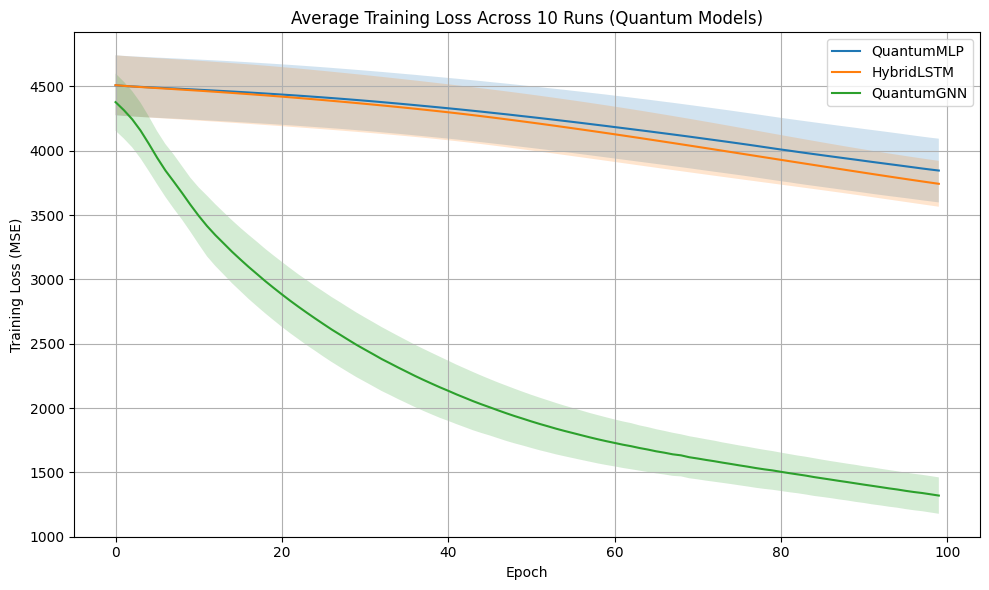

In [14]:
plt.figure(figsize=(10, 6))
for name, runs_losses in all_losses.items():
    losses_matrix = np.array([np.array(l) for l in runs_losses])
    mean_loss = losses_matrix.mean(axis=0)
    std_loss = losses_matrix.std(axis=0)
    epochs = np.arange(len(mean_loss))

    plt.plot(epochs, mean_loss, label=name)
    plt.fill_between(epochs, mean_loss - std_loss, mean_loss + std_loss, alpha=0.2)

plt.xlabel("Epoch")
plt.ylabel("Training Loss (MSE)")
plt.title("Average Training Loss Across 10 Runs (Quantum Models)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("loss_er_dataset_2.png", dpi=300)
plt.show()

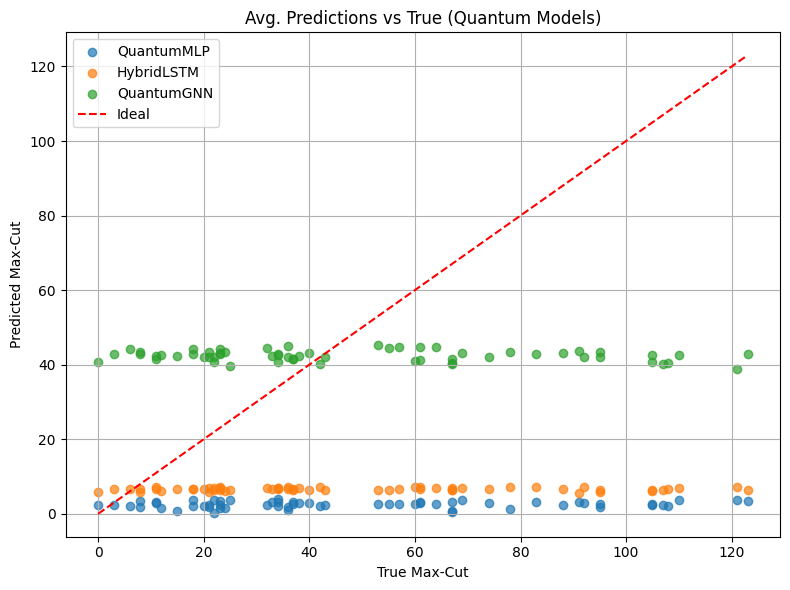

In [15]:
plt.figure(figsize=(8, 6))
true_vals = np.array(all_trues)

for name, runs_preds in all_preds.items():
    preds_matrix = np.array(runs_preds)
    mean_preds = preds_matrix.mean(axis=0)
    plt.scatter(true_vals, mean_preds, label=name, alpha=0.7)

lims = [min(true_vals.min(), mean_preds.min()), max(true_vals.max(), mean_preds.max())]
plt.plot(lims, lims, 'r--', label="Ideal")
plt.xlabel("True Max-Cut")
plt.ylabel("Predicted Max-Cut")
plt.title("Avg. Predictions vs True (Quantum Models)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("avg_pred_vs_true_er_dataset_2.png", dpi=300)
plt.show()

In [16]:
results_lines = []
results_lines.append("--- Aggregated Test Evaluation over All Runs (Quantum Models) ---\n")

true_vals = np.array(all_trues)

for name, runs_preds in all_preds.items():
    preds_matrix = np.array(runs_preds)
    mean_preds = preds_matrix.mean(axis=0)
    std_preds = preds_matrix.std(axis=0)
    # Metrics
    mse = mean_squared_error(true_vals, mean_preds)
    mae = mean_absolute_error(true_vals, mean_preds)
    approx_ratios = mean_preds / np.maximum(true_vals, 1e-6)
    mean_ratio = approx_ratios.mean()
    std_ratio = approx_ratios.std()
    # Store results as string
    results_lines.append(f"{name} Results:")
    results_lines.append(f"  MSE:            {mse:.4f}")
    results_lines.append(f"  MAE:            {mae:.4f}")
    results_lines.append(f"  Approx. Ratio:  {mean_ratio:.4f} ± {std_ratio:.4f}\n")

output_path = "results_er_dataset_2.txt"
with open(output_path, "w") as f:
    f.write("\n".join(results_lines))

print(f"\n✅ Quantum results saved to {output_path}")


✅ Quantum results saved to results_er_dataset_2.txt
